<a href="https://colab.research.google.com/github/elonezra/deeplearningproject/blob/main/final_project_deep_learning_course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors: Avi and Elon 🤗

## Pre-Processing the data

In [56]:
# Importng necassary libraries
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [80]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [81]:
# We don't need the "Adj Close" column because this column is the same as the "Close" column,
# we are going to check it before earasing to make sure our assumption is true.
print(df['Adj Close'].count(), df['Close'].count()) # In this line we can see that the number of lines in both of the columns is equal
print(len(df["Close"] == df["Adj Close"])) # and in this line we compared between those columns and get as result that all lines are equal
# thus, we can remove "Asj Close" column
df = df.drop(['Adj Close'], axis = 1)
df.head()

2713 2713
2713


,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [82]:
# here we add some new columns to our dataframe to check which column is more important to our model
df['Open_Close_Gap'] = (df['Open'] - df['Close'])
df['Open_Close_Mean'] = (df['Open'] + df['Close'])/2

In [83]:
# In the code below we will see that our dataframe uses an object column which is not good
# because we need a numeric dataframe so, we convert this column to int64 type
# by removing the '-' char
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2713 non-null   object 
 1   Open             2713 non-null   float64
 2   High             2713 non-null   float64
 3   Low              2713 non-null   float64
 4   Close            2713 non-null   float64
 5   Volume           2713 non-null   int64  
 6   Open_Close_Gap   2713 non-null   float64
 7   Open_Close_Mean  2713 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 169.7+ KB


In [84]:
df["Date"] = df["Date"].apply(lambda x: x.replace('-','')).apply(pd.to_numeric)

In [85]:
# Now, after we convert the "Date" column to numeric type, we can see the new data as request
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2713 non-null   int64  
 1   Open             2713 non-null   float64
 2   High             2713 non-null   float64
 3   Low              2713 non-null   float64
 4   Close            2713 non-null   float64
 5   Volume           2713 non-null   int64  
 6   Open_Close_Gap   2713 non-null   float64
 7   Open_Close_Mean  2713 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 169.7 KB


,Date,Open,High,Low,Close,Volume,Open_Close_Gap,Open_Close_Mean
0,20140917,465.864014,468.174011,452.421997,457.334015,21056800,8.529999,461.599015
1,20140918,456.859985,456.859985,413.104004,424.440002,34483200,32.419983,440.649993
2,20140919,424.102997,427.834991,384.532013,394.795990,37919700,29.307007,409.449494
3,20140920,394.673004,423.295990,389.882996,408.903992,36863600,-14.230988,401.788498
4,20140921,408.084991,412.425995,393.181000,398.821014,26580100,9.263977,403.453003


In [86]:
df['Year'] = df['Date'].astype(str).str.slice(0, 4)
df['Year']

0       2014
1       2014
2       2014
3       2014
4       2014
        ... 
2708    2022
2709    2022
2710    2022
2711    2022
2712    2022
Name: Year, Length: 2713, dtype: object

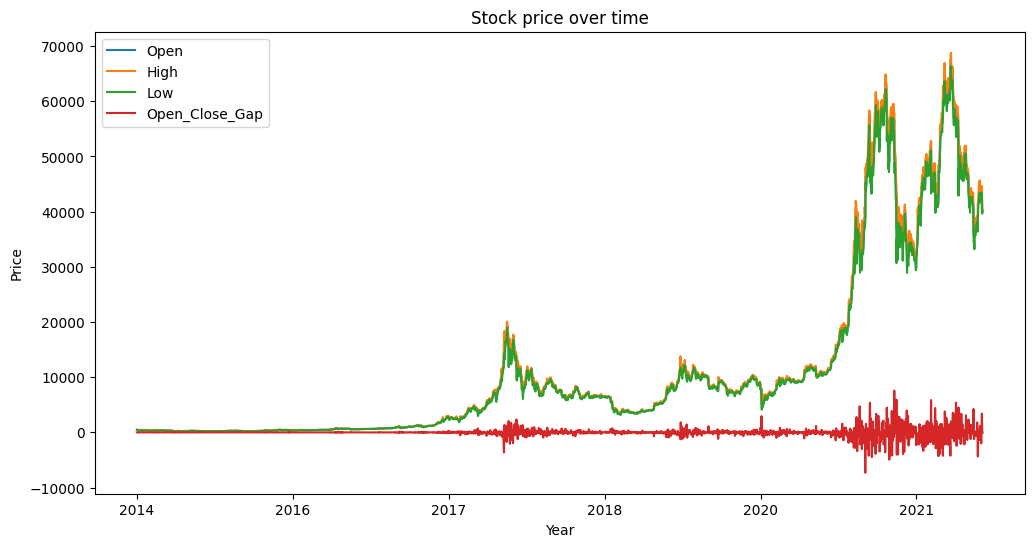

In [87]:
# Set 'Date' as the index
df.set_index('Year', inplace=True)

# Plot the data
df[['Open', 'High', 'Low', 'Open_Close_Gap']].plot(kind='line', figsize=(12,6))
plt.title('Stock price over time')
plt.ylabel('Price')
plt.show()




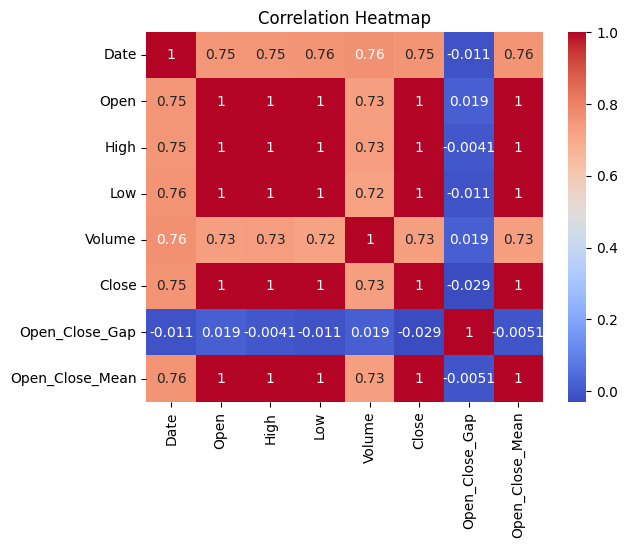

In [88]:
# Calculate the correlation matrix
df = df.reset_index()
corr = df[['Date', 'Open', 'High', 'Low', 'Volume', 'Close', 'Open_Close_Gap', 'Open_Close_Mean']].corr()

# Plot the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

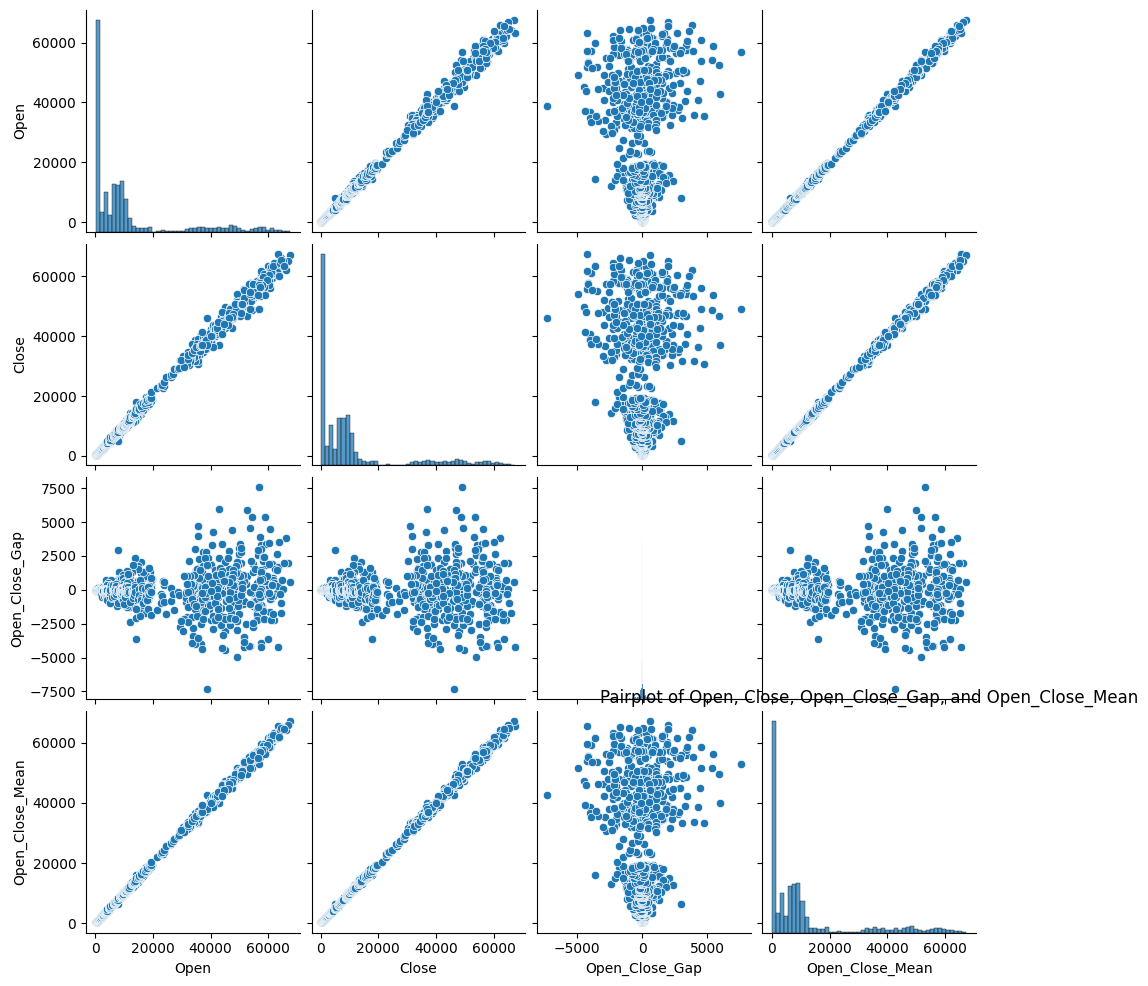

In [92]:
sns.pairplot(df[['Open', 'Close', 'Open_Close_Gap', 'Open_Close_Mean']])
plt.show()

In [94]:
df = df.drop(['Close', 'Open_Close_Mean', 'Year'], axis=1)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2713 non-null   int64  
 1   Open            2713 non-null   float64
 2   High            2713 non-null   float64
 3   Low             2713 non-null   float64
 4   Volume          2713 non-null   int64  
 5   Open_Close_Gap  2713 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 127.3 KB


In [96]:
df.head()

,Date,Open,High,Low,Volume,Open_Close_Gap
0,20140917,465.864014,468.174011,452.421997,21056800,8.529999
1,20140918,456.859985,456.859985,413.104004,34483200,32.419983
2,20140919,424.102997,427.834991,384.532013,37919700,29.307007
3,20140920,394.673004,423.295990,389.882996,36863600,-14.230988
4,20140921,408.084991,412.425995,393.181000,26580100,9.263977


In [69]:
X = df.drop(['Open_Close_Gap'], axis=1)
y = df['Open_Close_Gap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


Training set size: 2170
Testing set size: 543


# Normalization

In [70]:
def normalize_data(X_train, y_train, X_test, y_test):
    """
    This function normalizes the training and test data using the mean and variance of the training data.
    
    Parameters:
    X_train (DataFrame): The training data
    y_train (Series): The target values for the training data
    X_test (DataFrame): The test data
    y_test (Series): The target values for the test data
    
    Returns:
    DataFrame, Series, DataFrame, Series: The normalized training data, training target values, test data, and test target values
    """
    # Convert the dataframes to numpy arrays
    train_np = X_train.values
    test_np = X_test.values

    # Convert the series to numpy arrays
    y_train_np = y_train.values.reshape(-1, 1)
    y_test_np = y_test.values.reshape(-1, 1)

    # Create TensorFlow placeholders
    train_placeholder = tf.placeholder(tf.float32, shape=train_np.shape)
    test_placeholder = tf.placeholder(tf.float32, shape=test_np.shape)
    y_train_placeholder = tf.placeholder(tf.float32, shape=y_train_np.shape)
    y_test_placeholder = tf.placeholder(tf.float32, shape=y_test_np.shape)

    # Define the normalization function
    def normalize(x, mean, variance):
        return (x - mean) / tf.sqrt(variance)

    # Normalize the data
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Compute mean and variance from training data
        train_mean, train_variance = sess.run(tf.nn.moments(train_placeholder, axes=[0]), feed_dict={train_placeholder: train_np})
        
        # Normalize training data
        train_normalized = sess.run(normalize(train_placeholder, train_mean, train_variance), feed_dict={train_placeholder: train_np})
        
        # Normalize test data using mean and variance from training data
        test_normalized = sess.run(normalize(test_placeholder, train_mean, train_variance), feed_dict={test_placeholder: test_np})
        
        # Normalize y_train and y_test similarly
        y_train_mean, y_train_variance = sess.run(tf.nn.moments(y_train_placeholder, axes=[0]), feed_dict={y_train_placeholder: y_train_np})
        y_train_normalized = sess.run(normalize(y_train_placeholder, y_train_mean, y_train_variance), feed_dict={y_train_placeholder: y_train_np})
        y_test_normalized = sess.run(normalize(y_test_placeholder, y_train_mean, y_train_variance), feed_dict={y_test_placeholder: y_test_np})

    # Convert the normalized numpy arrays back to pandas dataframes
    X_train_normalized = pd.DataFrame(train_normalized, columns=X_train.columns)
    X_test_normalized = pd.DataFrame(test_normalized, columns=X_test.columns)

    # Convert the normalized numpy arrays back to pandas series
    y_train_normalized = pd.Series(y_train_normalized.flatten(), index=y_train.index)
    y_test_normalized = pd.Series(y_test_normalized.flatten(), index=y_test.index)

    return X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized


In [71]:
X_train_normalized, y_train_normalized, X_test_normalized, y_test_normalized = normalize_data(X_train, y_train, X_test, y_test)
print("Training set size:", len(X_train_normalized))
print("Testing set size:", len(X_test_normalized))


Training set size: 2170
Testing set size: 543


# Model training using Cross Validation
Models that represented in the code: Linear regression, ANN - neural network model, dummy regressor model - to compare our model to that dummy model

In [72]:
def train_linear_regression(X_train, y_train, learning_rate=0.001, threshold=0.0001, cv=5):
    """
    This function trains a linear regression model using TensorFlow and performs cross-validation.
    
    Parameters:
    X_train (DataFrame): The training data
    y_train (Series): The target values for the training data
    learning_rate (float): The learning rate for gradient descent
    threshold (float): The threshold for early stopping
    cv (int): The number of cross-validation folds

    Returns:
    Session, Tensor, Tensor: The trained TensorFlow session, the prediction tensor, and the input tensor
    """
    features = X_train.shape[1]
    x = tf.placeholder(tf.float32, [None, features])
    y = tf.placeholder(tf.float32, [None, 1])
    W = tf.Variable(tf.zeros([features, 1]))
    b = tf.Variable(tf.zeros([1]))
    pred = tf.matmul(x, W) + b
    loss = tf.reduce_mean(tf.square(pred - y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    data_x = X_train.values
    data_y = y_train.values.reshape(-1, 1)
    
    kf = KFold(n_splits=cv)
    scores = []
    best_score = np.inf
    best_weights = None
    for train_index, val_index in kf.split(data_x):
        X_train_cv, X_val_cv = data_x[train_index], data_x[val_index]
        y_train_cv, y_val_cv = data_y[train_index], data_y[val_index]
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        prev_loss = None
        i = 0
        while True:
            i += 1
            _, train_loss = sess.run([optimizer, loss], feed_dict={x: X_train_cv, y: y_train_cv})
            val_loss = sess.run(loss, feed_dict={x: X_val_cv, y: y_val_cv})
            if prev_loss is not None and abs(prev_loss - val_loss) < threshold:
                print(f"Early stopping at epoch {i}")
                break
            prev_loss = val_loss
        scores.append(val_loss)
        if val_loss < best_score:
            best_score = val_loss
            best_weights = sess.run([W, b])
    # After the cross-validation loop, plot the cross-validation scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, cv + 1), scores)
    plt.xlabel('CV Fold')
    plt.ylabel('Validation Loss')
    plt.title('Cross-Validation Scores')
    plt.show()

    print('Cross-Validation Scores:', scores)
    print('Average Cross-Validation Score:', np.mean(scores))
    
    # Retrain the model with the best weights on the full training set
    sess.run([tf.assign(W, best_weights[0]), tf.assign(b, best_weights[1])])
    i = 0
    prev_loss = None
    while True:
        i += 1
        _, train_loss = sess.run([optimizer, loss], feed_dict={x: data_x, y: data_y})
        if prev_loss is not None and abs(prev_loss - train_loss) < threshold:
            print(f"Early stopping at epoch {i}")
            break
        prev_loss = train_loss
    print('Final Training Loss for the ANN:', train_loss)
    
    return sess, pred, x


We replaced this code:
```
for epoch in range(0, epochs):
        _, c = sess.run([optimizer, loss], feed_dict={x: data_x, y: data_y})
        if epoch % 1000 == 0:
            print("Epoch:", '%04d' % (epoch), "cost=", "{:.9f}".format(c))
```
with this code below:
```
prev_loss = None
i = 0
while True:
        i += 1
        _, val_loss = sess.run([optimizer, loss], feed_dict={x: data_x, y: data_y})
        if prev_loss is not None and abs(prev_loss - val_loss) < threshold:
            print(f"Early stopping at epoch {i}")
            break
        prev_loss = val_loss
        if i % 10000 == 0:
            print('\nIteration:', i, '\n W1:', sess.run(W1), ' b1:', sess.run(b1), '\n W2:', sess.run(W2), ' b2:', sess.run(b2), ' loss:', loss.eval(session=sess, feed_dict={x: data_x, y: data_y}))
```

which is the same approach as in the Linear Regression model.
We apply "Early stopping" for the ANN model such that when the difference between the current cost and the previous cost is less than the threshold, so we will stop to train the model and break the loop.

This technique saves us to use Trial and error because it finds the optimal values for W1, b1, W2, b2 because if we keep changing the bias and weights it has no much effect on the cost value.

In [73]:
def train_neural_network(X_train, y_train, learning_rate=0.001, threshold=0.0001, cv=5):
    """
    This function trains a neural network model using TensorFlow.

    Parameters:
    X_train (DataFrame): The training data
    y_train (Series): The target values for the training data
    learning_rate (float): The learning rate for the optimizer
    threshold (float): The threshold for early stopping
    cv (int): The number of cross-validation folds

    Returns:
    Session, Tensor, Tensor: The TensorFlow session, the prediction tensor, and the input tensor
    """
    features = X_train.shape[1]
    x = tf.placeholder(tf.float32, [None, features])
    y = tf.placeholder(tf.float32, [None, 1])
    W1 = tf.Variable(tf.random_normal([features, 10]))
    b1 = tf.Variable(tf.zeros([10]))
    W2 = tf.Variable(tf.random_normal([10, 1]))
    b2 = tf.Variable(tf.zeros([1]))
    hidden_layer = tf.nn.relu(tf.matmul(x, W1) + b1)
    pred = tf.matmul(hidden_layer, W2) + b2
    loss = tf.reduce_mean(tf.square(pred - y))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    data_x = X_train.values
    data_y = y_train.values.reshape(-1, 1)
    
    kf = KFold(n_splits=cv)
    scores = []
    best_score = np.inf
    best_weights = None
    for train_index, val_index in kf.split(data_x):
        X_train_cv, X_val_cv = data_x[train_index], data_x[val_index]
        y_train_cv, y_val_cv = data_y[train_index], data_y[val_index]
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        prev_loss = None
        i = 0
        while True:
            i += 1
            _, train_loss = sess.run([optimizer, loss], feed_dict={x: X_train_cv, y: y_train_cv})
            val_loss = sess.run(loss, feed_dict={x: X_val_cv, y: y_val_cv})
            if prev_loss is not None and abs(prev_loss - val_loss) < threshold:
                print(f"Early stopping at epoch {i}")
                break
            prev_loss = val_loss
        scores.append(val_loss)
        if val_loss < best_score:
            best_score = val_loss
            best_weights = sess.run([W1, b1, W2, b2])
            
    # After the cross-validation loop, plot the cross-validation scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, cv + 1), scores)
    plt.xlabel('CV Fold')
    plt.ylabel('Validation Loss')
    plt.title('Cross-Validation Scores')
    plt.show()

    print('Cross-Validation Scores:', scores)
    print('Average Cross-Validation Score:', np.mean(scores))
    
    # Retrain the model with the best weights on the full training set
    sess.run([tf.assign(W1, best_weights[0]), tf.assign(b1, best_weights[1]), tf.assign(W2, best_weights[2]), tf.assign(b2, best_weights[3])])
    i = 0
    prev_loss = None
    while True:
        i += 1
        _, train_loss = sess.run([optimizer, loss], feed_dict={x: data_x, y: data_y})
        if prev_loss is not None and abs(prev_loss - train_loss) < threshold:
            print(f"Early stopping at epoch {i}")
            break
        prev_loss = train_loss
    print('Final Training Loss for the ANN:', train_loss)
    
    return sess, pred, x

#### Create dummy model

In [74]:
def dummy_regressor(y_train):
    """
    This function creates a dummy regressor that predicts the mean value of the target variable.
    
    Parameters:
    X_train (DataFrame): The training data
    y_train (Series): The target values for the training data
    
    Returns:
    y_pred (ndarray): The predicted values
    """
    y_pred = [(np.random.uniform(-1,1)) for i in range(len(y_train))]
    return y_pred

In [75]:
dummy_pred = dummy_regressor(y_test_normalized)
print("y_dummy_pred:", dummy_pred)

y_dummy_pred: [0.1439295337939095, -0.5320634685016963, 0.5585321149481011, 0.3594379131173431, -0.6526769102952876, 0.8777977804712287, -0.47407456840889406, -0.17506237962726656, -0.37609938517630814, 0.06574766160216106, -0.06004462742123251, -0.48681505000540337, 0.44308027244034753, -0.6458744852938136, 0.01860630179087397, -0.8592700941328755, -0.30133268745040587, 0.14003307819950384, 0.12683298089993844, -0.03732698775563548, 0.6328711103553619, 0.38477644233591834, 0.890618197913426, 0.07544604885241668, -0.2859866387121437, -0.1959778531938583, 0.3057691556304052, -0.15816513351074524, 0.3940205408119417, 0.887362436058456, 0.3824788000315169, 0.9537092476134985, -0.8265502757453116, 0.11917693939970508, 0.5026233689270196, 0.9529205798365565, 0.948188446380646, -0.9793975779102924, -0.9209679895744454, 0.4384999157651095, 0.8484460001424341, -0.8692647649619551, -0.14165649419182258, 0.43608353442101855, -0.626760382364413, -0.30876959650697855, 0.9869023650718776, 0.3920144

Training Linear Regression model with the best parameters given by cross-validation...


Early stopping at epoch 138765
Early stopping at epoch 161260
Early stopping at epoch 86
Early stopping at epoch 158714
Early stopping at epoch 158204


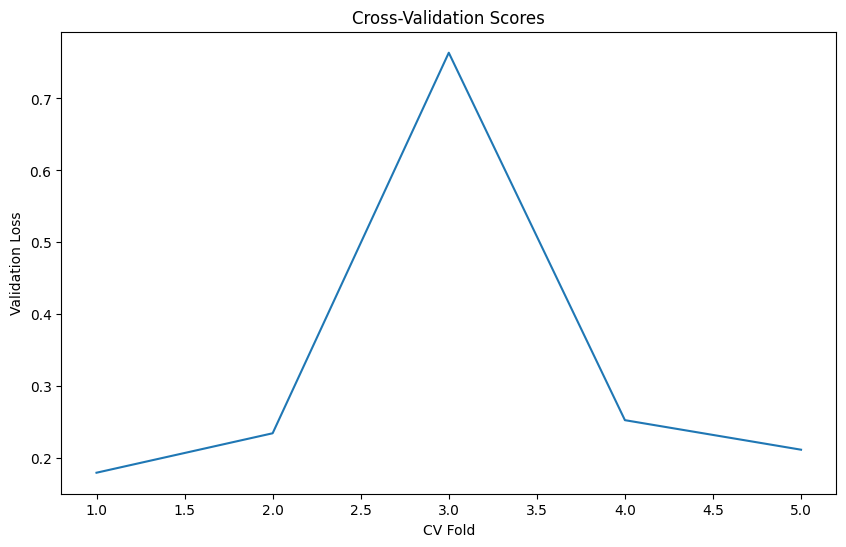

Cross-Validation Scores: [0.17964453, 0.23450336, 0.7636414, 0.25272214, 0.21164468]
Average Cross-Validation Score: 0.32843122
Early stopping at epoch 53623
Final Training Loss for the ANN: 0.18480867
Training Neural Network model with the best parameters given by cross-validation...
Early stopping at epoch 13540
Early stopping at epoch 68707
Early stopping at epoch 2845
Early stopping at epoch 7057
Early stopping at epoch 60215


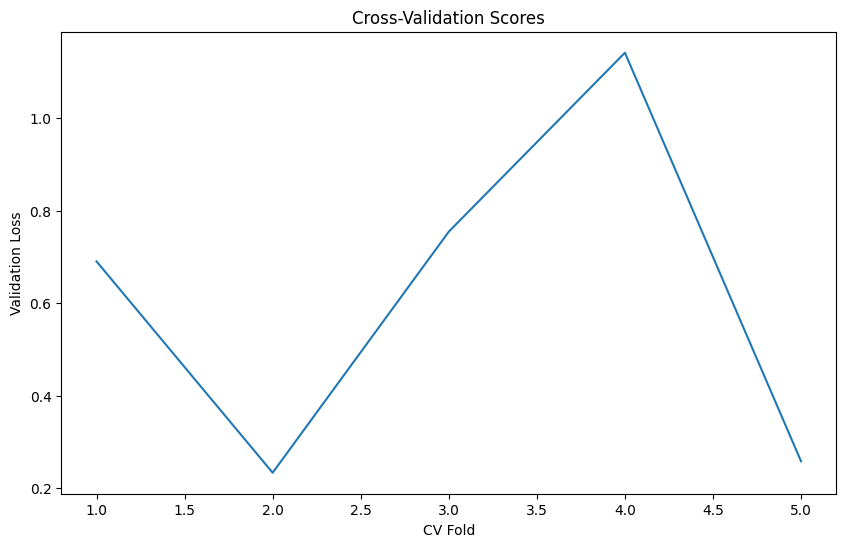

Cross-Validation Scores: [0.6902684, 0.2334208, 0.7544756, 1.1413376, 0.25821158]
Average Cross-Validation Score: 0.61554277
Early stopping at epoch 18897
Final Training Loss for the ANN: 0.17216487
R-Squared scores in the training set: linear regression: 0.8151917102590073, neural network: 0.8278353167093198, dummy model: -0.3034934395710971
R-Squared scores in the test set: linear regression: 0.778332252047607, neural network: 0.7972712593961253, dummy model: -0.39354824860435955
MSE in the test set: linear regression: 0.19867399334907532, neural network: 0.18169955909252167, dummy model: 1.248994515548063


In [76]:
# Train the models
print("Training Linear Regression model with the best parameters given by cross-validation...")
sess_linear, pred_linear, x_linear = train_linear_regression(X_train_normalized, y_train_normalized, learning_rate=0.01, threshold=0.0000000000001)
print("Training Neural Network model with the best parameters given by cross-validation...")
sess_nn, pred_nn, x_nn = train_neural_network(X_train_normalized, y_train_normalized, learning_rate=0.001, threshold=0.0000000000001)
# Make predictions
y_pred_linear = sess_linear.run(pred_linear, feed_dict={x_linear: X_test_normalized.values})
y_pred_nn = sess_nn.run(pred_nn, feed_dict={x_nn: X_test_normalized.values})

# Calculate R-Squared score
r2_linear_train = r2_score(y_train_normalized, sess_linear.run(pred_linear, feed_dict={x_linear: X_train_normalized.values}))
r2_nn_train = r2_score(y_train_normalized, sess_nn.run(pred_nn, feed_dict={x_nn: X_train_normalized.values}))
r2_dummy_train = r2_score(y_train_normalized, dummy_regressor(y_train_normalized))

r2_linear_test = r2_score(y_test_normalized, y_pred_linear)
r2_nn_test = r2_score(y_test_normalized, y_pred_nn)
r2_dummy_test = r2_score(y_test_normalized, dummy_pred)

mse_linear = mean_squared_error(y_test_normalized, y_pred_linear)
mse_nn = mean_squared_error(y_test_normalized, y_pred_nn)
mse_dummy = mean_squared_error(y_test_normalized, dummy_pred)

print(f"R-Squared scores in the training set: linear regression: {r2_linear_train}, neural network: {r2_nn_train}, dummy model: {r2_dummy_train}")
print(f"R-Squared scores in the test set: linear regression: {r2_linear_test}, neural network: {r2_nn_test}, dummy model: {r2_dummy_test}")
print(f"MSE in the test set: linear regression: {mse_linear}, neural network: {mse_nn}, dummy model: {mse_dummy}")

# Comparison between models

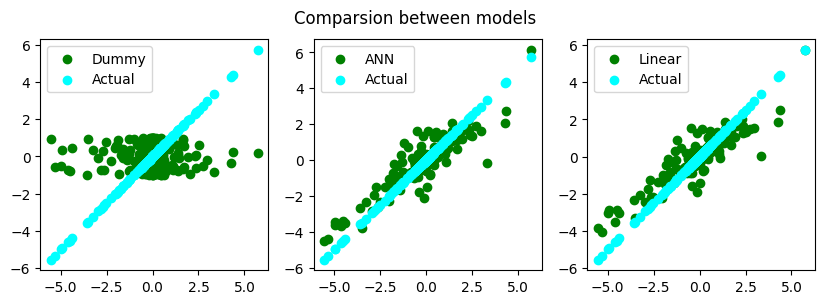

In [77]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
fig.suptitle('Comparsion between models')

ax1.scatter(y_test_normalized, dummy_pred, color='green', label='Dummy')
ax1.scatter(y_test_normalized, y_test_normalized, color='cyan', label='Actual')
ax1.legend()

ax2.scatter(y_test_normalized, y_pred_nn, color='green', label='ANN')
ax2.scatter(y_test_normalized, y_test_normalized, color='cyan', label='Actual')
ax2.legend()

ax3.scatter(y_test_normalized, y_pred_linear, color='green', label='Linear')
ax3.scatter(y_test_normalized, y_test_normalized, color='cyan', label='Actual')
ax3.legend()


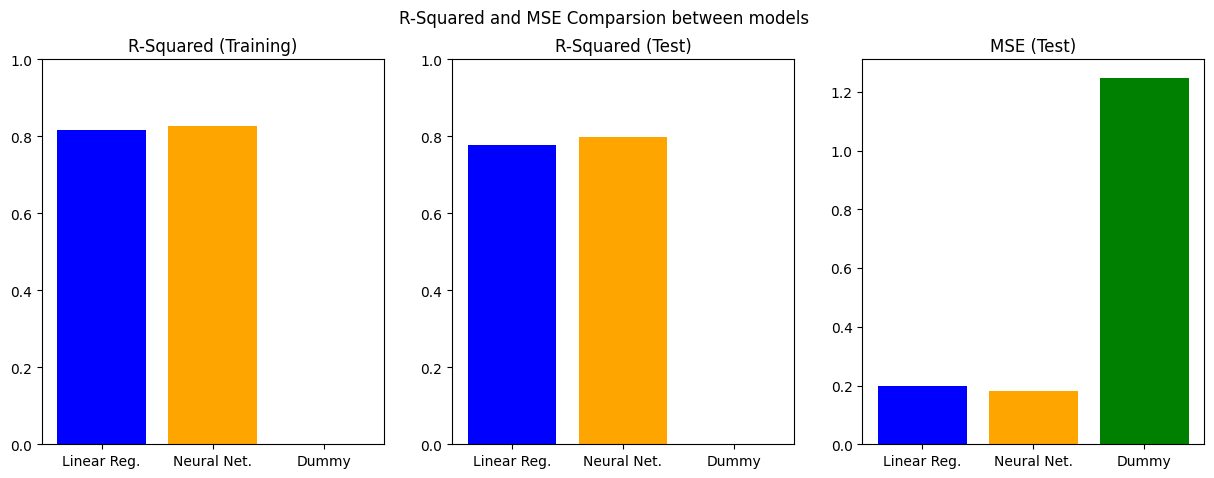

In [78]:

"""
This code generates bar plots for the R-Squared scores and Mean Squared Error (MSE) for different models on the training and test sets.
"""
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('R-Squared and MSE Comparsion between models')

ax1.bar(['Linear Reg.', 'Neural Net.', 'Dummy'], [r2_linear_train, r2_nn_train, r2_dummy_train], color=['blue', 'orange', 'green'])
ax1.set_title('R-Squared (Training)')
ax1.set_ylim(0, 1)

ax2.bar(['Linear Reg.', 'Neural Net.', 'Dummy'], [r2_linear_test, r2_nn_test, r2_dummy_test], color=['blue', 'orange', 'green'])
ax2.set_title('R-Squared (Test)')
ax2.set_ylim(0, 1)

ax3.bar(['Linear Reg.', 'Neural Net.', 'Dummy'], [mse_linear, mse_nn, mse_dummy], color=['blue', 'orange', 'green'])
ax3.set_title('MSE (Test)')
plt.show()